<a href="https://colab.research.google.com/github/EmaSuriano/pytorch-demo/blob/main/atari-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DeepQN Tutorial

Based on [Reinforcement Learning (DQN) Tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)


## Dependencies

In [3]:
import torch

# https://pytorch.org/get-started/locally/
print("Torch is properly installed!")

Torch is properly installed!


In [4]:
%pip install gymnasium[atari] matplotlib opencv-python imageio[ffmpeg] ale-py

## Imports

In [5]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import ale_py

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

gym.register_envs(ale_py)

# Set general env ID to re-use it
# ENV_ID = "SpaceInvadersNoFrameskip-v4"
ENV_ID = "ALE/SpaceInvaders-v5"

# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [6]:
# if GPU is to be used
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

device

device(type='cuda')

## Atari Wrappers

In [7]:
"""Implementation of Atari 2600 Preprocessing following the guidelines of Machado et al., 2018."""
import numpy as np

import gymnasium as gym
from gymnasium.spaces import Box
# from gymnasium.utils.step_api_compatibility import step_api_compatibility

try:
    import cv2
except ImportError:
    cv2 = None


class AtariPreprocessing(gym.Wrapper):
    """Atari 2600 preprocessing wrapper.

    This class follows the guidelines in Machado et al. (2018),
    "Revisiting the Arcade Learning Environment: Evaluation Protocols and Open Problems for General Agents".

    Specifically, the following preprocess stages applies to the atari environment:
    - Noop Reset: Obtains the initial state by taking a random number of no-ops on reset, default max 30 no-ops.
    - Frame skipping: The number of frames skipped between steps, 4 by default
    - Max-pooling: Pools over the most recent two observations from the frame skips
    - Termination signal when a life is lost: When the agent losses a life during the environment, then the environment is terminated.
        Turned off by default. Not recommended by Machado et al. (2018).
    - Resize to a square image: Resizes the atari environment original observation shape from 210x180 to 84x84 by default
    - Grayscale observation: If the observation is colour or greyscale, by default, greyscale.
    - Scale observation: If to scale the observation between [0, 1) or [0, 255), by default, not scaled.
    """

    def __init__(
        self,
        env: gym.Env,
        noop_max: int = 30,
        frame_skip: int = 4,
        screen_size: int = 84,
        terminal_on_life_loss: bool = False,
        grayscale_obs: bool = True,
        grayscale_newaxis: bool = False,
        scale_obs: bool = False
    ):
        """Wrapper for Atari 2600 preprocessing.

        Args:
            env (Env): The environment to apply the preprocessing
            noop_max (int): For No-op reset, the max number no-ops actions are taken at reset, to turn off, set to 0.
            frame_skip (int): The number of frames between new observation the agents observations effecting the frequency at which the agent experiences the game.
            screen_size (int): resize Atari frame
            terminal_on_life_loss (bool): `if True`, then :meth:`step()` returns `terminated=True` whenever a
                life is lost.
            grayscale_obs (bool): if True, then gray scale observation is returned, otherwise, RGB observation
                is returned.
            grayscale_newaxis (bool): `if True and grayscale_obs=True`, then a channel axis is added to
                grayscale observations to make them 3-dimensional.
            scale_obs (bool): if True, then observation normalized in range [0,1) is returned. It also limits memory
                optimization benefits of FrameStack Wrapper.

        Raises:
            DependencyNotInstalled: opencv-python package not installed
            ValueError: Disable frame-skipping in the original env
        """
        super().__init__(env)
        if cv2 is None:
            raise gym.error.DependencyNotInstalled(
                "opencv-python package not installed, run `pip install gym[other]` to get dependencies for atari"
            )
        assert frame_skip > 0
        assert screen_size > 0
        assert noop_max >= 0
        if frame_skip > 1:
            if (
                "NoFrameskip" not in env.spec.id
                and getattr(env.unwrapped, "_frameskip", None) != 1
            ):
                raise ValueError(
                    "Disable frame-skipping in the original env. Otherwise, more than one "
                    "frame-skip will happen as through this wrapper"
                )
        self.noop_max = noop_max
        assert env.unwrapped.get_action_meanings()[0] == "NOOP"

        self.frame_skip = frame_skip
        self.screen_size = screen_size
        self.terminal_on_life_loss = terminal_on_life_loss
        self.grayscale_obs = grayscale_obs
        self.grayscale_newaxis = grayscale_newaxis
        self.scale_obs = scale_obs

        # buffer of most recent two observations for max pooling
        assert isinstance(env.observation_space, Box)
        if grayscale_obs:
            self.obs_buffer = [
                np.empty(env.observation_space.shape[:2], dtype=np.uint8),
                np.empty(env.observation_space.shape[:2], dtype=np.uint8),
            ]
        else:
            self.obs_buffer = [
                np.empty(env.observation_space.shape, dtype=np.uint8),
                np.empty(env.observation_space.shape, dtype=np.uint8),
            ]

        self.ale = env.unwrapped.ale
        self.lives = 0
        self.game_over = False

        _low, _high, _obs_dtype = (
            (0, 255, np.uint8) if not scale_obs else (0, 1, np.float32)
        )
        _shape = (screen_size, screen_size, 1 if grayscale_obs else 3)
        if grayscale_obs and not grayscale_newaxis:
            _shape = _shape[:-1]  # Remove channel axis
        self.observation_space = Box(
            low=_low, high=_high, shape=_shape, dtype=_obs_dtype
        )

    def step(self, action):
        """Applies the preprocessing for an :meth:`env.step`."""
        total_reward, terminated, truncated, info = 0.0, False, False, {}

        for t in range(self.frame_skip):
            # _, reward, terminated, truncated, info = step_api_compatibility(
            #     self.env.step(action), True
            # )
            _, reward, terminated, truncated, info = self.env.step(action)

            total_reward += reward
            self.game_over = terminated

            if self.terminal_on_life_loss:
                new_lives = self.ale.lives()
                terminated = terminated or new_lives < self.lives
                self.game_over = terminated
                self.lives = new_lives

            if terminated or truncated:
                break
            if t == self.frame_skip - 2:
                if self.grayscale_obs:
                    self.ale.getScreenGrayscale(self.obs_buffer[1])
                else:
                    self.ale.getScreenRGB(self.obs_buffer[1])
            elif t == self.frame_skip - 1:
                if self.grayscale_obs:
                    self.ale.getScreenGrayscale(self.obs_buffer[0])
                else:
                    self.ale.getScreenRGB(self.obs_buffer[0])

        return self._get_obs(), total_reward, terminated, truncated, info

    def reset(self, **kwargs):
        """Resets the environment using preprocessing."""
        # NoopReset
        if kwargs.get("return_info", False):
            _, reset_info = self.env.reset(**kwargs)
        else:
            _ = self.env.reset(**kwargs)
            reset_info = {}

        noops = (
            self.env.unwrapped.np_random.integers(1, self.noop_max + 1)
            if self.noop_max > 0
            else 0
        )
        for _ in range(noops):
            # _, _, terminated, truncated, step_info = step_api_compatibility(
            #     self.env.step(0), True
            # )
            _, _, terminated, truncated, step_info = self.env.step(0)
            reset_info.update(step_info)
            if terminated or truncated:
                if kwargs.get("return_info", False):
                    _, reset_info = self.env.reset(**kwargs)
                else:
                    _ = self.env.reset(**kwargs)
                    reset_info = {}

        self.lives = self.ale.lives()
        if self.grayscale_obs:
            self.ale.getScreenGrayscale(self.obs_buffer[0])
        else:
            self.ale.getScreenRGB(self.obs_buffer[0])
        self.obs_buffer[1].fill(0)

        if kwargs.get("return_info", False):
            return self._get_obs(), reset_info
        else:
            return self._get_obs()

    def _get_obs(self):
        if self.frame_skip > 1:  # more efficient in-place pooling
            np.maximum(self.obs_buffer[0], self.obs_buffer[1], out=self.obs_buffer[0])
        assert cv2 is not None
        obs = cv2.resize(
            self.obs_buffer[0],
            (self.screen_size, self.screen_size),
            interpolation=cv2.INTER_AREA,
        )

        if self.scale_obs:
            obs = np.asarray(obs, dtype=np.float32) / 255.0
        else:
            obs = np.asarray(obs, dtype=np.uint8)

        if self.grayscale_obs and self.grayscale_newaxis:
            obs = np.expand_dims(obs, axis=-1)  # Add a channel axis
        return obs


In [8]:
from gymnasium.wrappers import ClipReward, RecordVideo

def create_env(env_name: str, video_per_episode = 50):
    env = gym.make(env_name, frameskip=1, render_mode='rgb_array')

    trigger = lambda t: t % video_per_episode == 0

    env = RecordVideo(env, video_folder="./videos", episode_trigger=trigger, disable_logger=True)

    env = AtariPreprocessing(
      env, noop_max=0,
      frame_skip=4,
      terminal_on_life_loss=False,
      screen_size=84
    )

    env = ClipReward(env, 0, 1)
    # env = NumpyToTorch(env)

    return env

## Test Env + video generation

In [9]:
def test_env(env_test, take_action, num_episodes=5):
    scores = []

    for i in range(num_episodes):
        observation = env_test.reset(seed=42)
        done = False
        score = 0

        while not done:
            # get next action
            action = take_action(observation)

            # take a step in the env
            observation, reward, terminated, truncated, info = env_test.step(action)

            # Collect rewards
            score += reward

            # set if done
            done = terminated or truncated

        print(f"Episode {i+1}: {score}")
        scores.append(score)

    print(f"Episode Avg: {np.mean(scores)}")
    env_test.close()

env = create_env(ENV_ID)

test_env(env, lambda obs: env.action_space.sample())

Episode 1: 8.0
Episode 2: 3.0
Episode 3: 10.0
Episode 4: 5.0
Episode 5: 5.0
Episode Avg: 6.2


## DQN

In [10]:
class DQN(nn.Module):
    def __init__(self, in_channels, n_actions):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, n_actions)

    def forward(self, x):
        """
        Input shape: (bs,c,h,w) #(bs,4,84,84)
        Output shape: (bs,n_actions)
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

## Replay Memory

In [11]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Hyper-parameters

In [44]:
# Replay buffer batch size
BATCH_SIZE = 128  # Standard size for stable training; adjust if needed.

# Discount factor for future rewards
GAMMA = 0.99  # Balances immediate vs. long-term rewards; 0.99 is standard.

# Epsilon-greedy strategy
EPS_START = 0.9  # Start with 90% exploration.
EPS_END = 0.05   # End with 5% exploration.
EPS_DECAY = 100  # Slower decay for better exploration in complex environments.

# Target network soft update rate
TAU = 0.005  # Conservative value to ensure target network stability.

# Learning rate for AdamW optimizer
LR = 1e-3  # Standard for AdamW; can use a scheduler for dynamic adjustment.

# Total episodes for training
NUM_EPISODES = 1000  # Increased for complex environments.

# Video recording for debugging and evaluation
VIDEO_PER_EPISODE = 50  # Save evaluation videos every 50 episodes.

## Epsilon Greedy

In [13]:
def select_action(state: torch.Tensor, epsilon: float) -> torch.Tensor:
    # Epsilon-greedy selection: either choose the best action or random action
    if random.random() > epsilon:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)  # Select best action
    else:
        return torch.tensor([[env.action_space.sample()]], device=device)  # Random action

## Plot Duration

In [38]:
def plot_results(values, moving_avg_window=20, show_result=False):
    if(len(values) <= 1):
      return

    plt.figure(1)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")

    # Plot the original values (e.g., the scores or rewards per episode)
    plt.plot(values, label="Episode Rewards")

    if(len(values) >= moving_avg_window):
      # Calculate the moving average of the last `moving_avg_window` episodes
      moving_avg = np.convolve(values, np.ones(moving_avg_window) / moving_avg_window, mode='valid')

      # Plot the moving average line
      plt.plot(np.arange(moving_avg_window - 1, len(values)), moving_avg, label=f"Avg (last {moving_avg_window} episodes)", color='red', linestyle='--')

    plt.xlabel("Episode")
    plt.ylabel("Value")
    plt.legend()

    # plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.display(plt.gcf())
        if not show_result:
            display.clear_output(wait=True)

## Optimize

In [15]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = (
            target_net(non_final_next_states).max(1).values
        )
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

## Train loop

KeyboardInterrupt: 

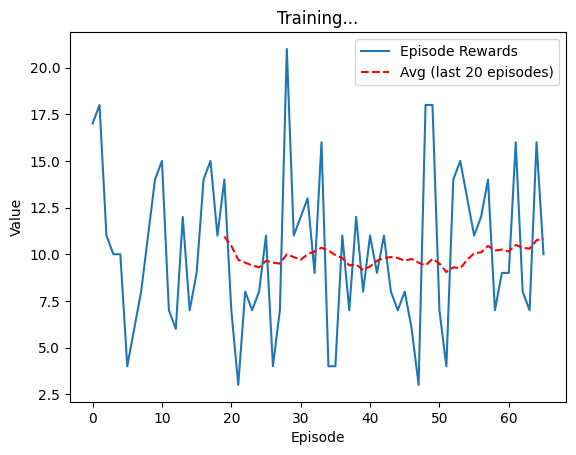

In [43]:
env = create_env(ENV_ID, video_per_episode=VIDEO_PER_EPISODE)

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(in_channels=4, n_actions=n_actions).to(device)
target_net = DQN(in_channels=4, n_actions=n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(50000)

# keep track of score per episode
episode_scores = []

for i_episode in range(NUM_EPISODES):
    # Initialize the environment and get its state
    state = env.reset()

    state = torch.from_numpy(state.astype(np.float32)).to(device)  # (84,84)
    # stack four frames together, hoping to learn temporal info
    state = torch.stack((state, state, state, state)).unsqueeze(0)  # (1,4,84,84)

    done = False
    score = 0

    while not done:
        epsilon = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * i_episode / EPS_DECAY)

        action = select_action(state, epsilon)
        obs, reward, terminated, truncated, _ = env.step(action.item())
        score += reward

        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        # if terminated:
        #     next_state = None
        # else:
        next_state = torch.from_numpy(obs.astype(np.float32)).to(device)  # (84,84)
        next_state = torch.stack(
          (
            next_state,
            state[0][0],
            state[0][1],
            state[0][2],
          )
        ).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        # for key in policy_net_state_dict:
        #     target_net_state_dict[key] = policy_net_state_dict[
        #         key
        #     ] * TAU + target_net_state_dict[key] * (1 - TAU)

        for key in policy_net_state_dict:
          target_net_state_dict[key] =  target_net_state_dict[key] * (1 - TAU) + policy_net_state_dict[key] * TAU

        target_net.load_state_dict(target_net_state_dict)


    print(f"Episode {i_episode+1}: {score} {epsilon}")
    episode_scores.append(score)
    plot_results(episode_scores)

print("Complete")
plot_results(episode_scores, show_result=True)
plt.ioff()
plt.show()

## Test agent

In [117]:
import gymnasium as gym

# Initialise the environment
env = gym.make(ENV_ID)
env = AtariWrapper(env)

# Run 5 episodes
num_episodes = 5

for i in range(num_episodes):
    obs, info = env.reset(seed=42)
    done = False
    score = 0

    print(obs)
    while not done:
        with torch.no_grad():
            obs = torch.tensor(
                obs, dtype=torch.float32, device=device
            ).unsqueeze(0)
            print(obs.shape)
            action = policy_net(obs).max(1).indices.view(1, 1)

        # step (transition) through the environment with the action
        # receiving the next obs, reward and if the episode has terminated or truncated
        obs, reward, terminated, truncated, info = env.step(action.item())

        # Collect rewards
        score += reward

        # set if done
        done = terminated or truncated

    print(f"Episode {i+1}: {score}")

env.close()

  and should_run_async(code)



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
torch.Size([1, 84, 84])


RuntimeError: Given groups=1, weight of size [32, 4, 8, 8], expected input[1, 1, 84, 84] to have 4 channels, but got 1 channels instead